# MSCA 31008 - Data Mining Assignment 4 Part 2 (Group 4)
<b>Qingwei Zhang, Jake Brewer, Prinu Mathew</b><br>
<b>Winter 2023</b>

### Import Libraries  

In [14]:
import sys, os, json, subprocess

## for data
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [15]:
## for machine learning
try:
    from sklearn.model_selection import train_test_split, GridSearchCV
    from sklearn.tree import DecisionTreeClassifier, export_graphviz
    from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_auc_score, roc_curve, accuracy_score

    import graphviz
        
    print("~~~ Already installed required packages for machine learning ~~~~")
except Exception as e:
    print(e)
    
    print("~~~ Installing required packages for machine learning ~~~~")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "kneed"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "scikit-learn"])
    from sklearn.model_selection import train_test_split, GridSearchCV
    from sklearn.tree import DecisionTreeClassifier, export_graphviz
    from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_auc_score, roc_curve, accuracy_score

    import graphviz

~~~ Already installed required packages for machine learning ~~~~


In [16]:
## for interactive visualization
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    print("~~~ Already installed required packages for interactive visualizations ~~~~")
except Exception as e:
    print(e)
    
    print("~~~ Installing required packages for interactive visualizations ~~~~")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "matplotlib"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "seaborn"])
    import matplotlib.pyplot as plt
    import seaborn as sns
    
%matplotlib inline

~~~ Already installed required packages for interactive visualizations ~~~~


## 0. Load and Explore Data (from Part 1)

In [17]:
# import the preprocess data from part 1

df = pd.read_csv('diabetes_data_preprocess.csv')
df.head()

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,change,...,troglitazone_Steady,tolazamide_Steady,insulin_No,insulin_Steady,insulin_Up,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,glipizide-metformin_Steady,metformin-pioglitazone_Steady
0,15,3,59,0,18,0,0,0,9,1,...,0,0,0,0,1,1,0,0,0,0
1,25,2,11,5,13,2,0,1,6,0,...,0,0,1,0,0,1,0,0,0,0
2,35,2,44,1,16,0,0,0,7,1,...,0,0,0,0,1,1,0,0,0,0
3,45,1,51,0,8,0,0,0,5,1,...,0,0,0,1,0,1,0,0,0,0
4,55,3,31,6,16,0,0,0,9,0,...,0,0,0,1,0,1,0,0,0,0


In [18]:
# view data types and number of non-null values in each column

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68630 entries, 0 to 68629
Columns: 102 entries, age to metformin-pioglitazone_Steady
dtypes: int64(102)
memory usage: 53.4 MB


## 1. Split Data into Training (70%) and Testing (30%)

In [19]:
# split into train and test using random state for reproducable results
# exact same split as used in part 1

X = df.drop(columns=['readmitted'])
y = df['readmitted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
y_train.value_counts()

0    28603
1    19438
Name: readmitted, dtype: int64

## 2. Perform Cross Validation to find best Hyper-Parameters

In [20]:
# run grid search cross validation to find best regularization hyper-parameters

param_map = {'max_depth':[5, 7, 9],
             'criterion': ['gini', 'entropy', 'log_loss'],
             'max_features': ['auto', 'sqrt', 'log2'],
             'max_leaf_nodes': [8, 10, 12],
             }

# specify class_weight='balanced' to account for imbalance in re-admitted and non re-admitted patients
clf = DecisionTreeClassifier(class_weight='balanced', random_state=42)
clf_gs = GridSearchCV(clf, param_grid=param_map, cv=5, n_jobs=-1, verbose=2)
clf_gs.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [5, 7, 9],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'max_leaf_nodes': [8, 10, 12]},
             verbose=2)

In [21]:
pd.DataFrame(clf_gs.cv_results_, 
columns=["rank_test_score", "max_depth", "param_criterion", "param_max_depth","param_max_features", "param_max_leaf_nodes","mean_test_score", "std_test_score"]).sort_values(by=['rank_test_score'])

,rank_test_score,max_depth,param_criterion,param_max_depth,param_max_features,param_max_leaf_nodes,mean_test_score,std_test_score
29,1,NaN,entropy,5,auto,12,0.577049,0.024480
2,1,NaN,gini,5,auto,12,0.577049,0.024480
5,1,NaN,gini,5,sqrt,12,0.577049,0.024480
32,1,NaN,entropy,5,sqrt,12,0.577049,0.024480
1,5,NaN,gini,5,auto,10,0.571720,0.039393
...,...,...,...,...,...,...,...,...
56,77,NaN,log_loss,5,auto,12,NaN,NaN
54,78,NaN,log_loss,5,auto,8,NaN,NaN
79,79,NaN,log_loss,9,log2,10,NaN,NaN
66,80,NaN,log_loss,7,sqrt,8,NaN,NaN


In [22]:
# identify best hyper-parameters

best_criterion = clf_gs.best_params_['criterion']
best_depth = clf_gs.best_params_['max_depth']
best_feat = clf_gs.best_params_['max_features']
best_nodes = clf_gs.best_params_['max_leaf_nodes']

clf_gs.best_params_

{'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'max_leaf_nodes': 12}

In [23]:
# identify most important features

best_model = clf_gs.best_estimator_
imp_top_features = pd.DataFrame({'Feature': X_train.columns, 'Importance': best_model.feature_importances_})
imp_top_features = imp_top_features[imp_top_features['Importance'] > 0]
imp_top_features_sorted = imp_top_features.sort_values(by='Importance', ascending=False)
imp_top_features_sorted

,Feature,Importance
7,number_inpatient,0.261682
5,number_outpatient,0.162068
0,age,0.150630
6,number_emergency,0.127271
41,discharge_disposition_id_6,0.126808
1,time_in_hospital,0.094073
3,num_procedures,0.032412
4,num_medications,0.024535
2,num_lab_procedures,0.020522


## 3. Build Best Model on Training Data

In [24]:
# use top 10 features and best hyper-parameters to fit a best model

imp_top_features = imp_top_features_sorted['Feature'].iloc[:len(imp_top_features_sorted)]
X_train = X_train[imp_top_features]
X_test = X_test[imp_top_features]

clf_trim = DecisionTreeClassifier(class_weight='balanced', criterion=best_criterion, max_depth=best_depth, 
                             max_features=best_feat, max_leaf_nodes=best_nodes, random_state=42)

clf_trim.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=5,
                       max_features='auto', max_leaf_nodes=12, random_state=42)

In [25]:
# predict on the test set
y_pred = clf_trim.predict(X_test)

# evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy after cross validation:", accuracy)

Accuracy after cross validation: 0.6080916994511633


## 4. Generate Confusion Matrix on Training Data

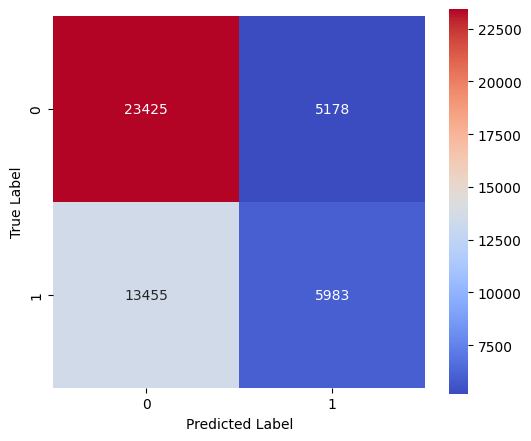

              precision    recall  f1-score   support

           0       0.64      0.82      0.72     28603
           1       0.54      0.31      0.39     19438

    accuracy                           0.61     48041
   macro avg       0.59      0.56      0.55     48041
weighted avg       0.60      0.61      0.58     48041



In [26]:
# make predictions for training data

y_pred = clf_trim.predict(X_train)

# create confusion matrix and classification report
fig, ax = plt.subplots(figsize=(6, 5))
mat = confusion_matrix(y_train, y_pred)
sns.heatmap(mat, square=True, annot=True, fmt='d', cmap='coolwarm', xticklabels=[0, 1], yticklabels=[0, 1])
ax.set(xlabel='Predicted Label')
ax.set(ylabel='True Label')
plt.show()
print(classification_report(y_train, y_pred))

## 5. Plot decision tree from Training Data

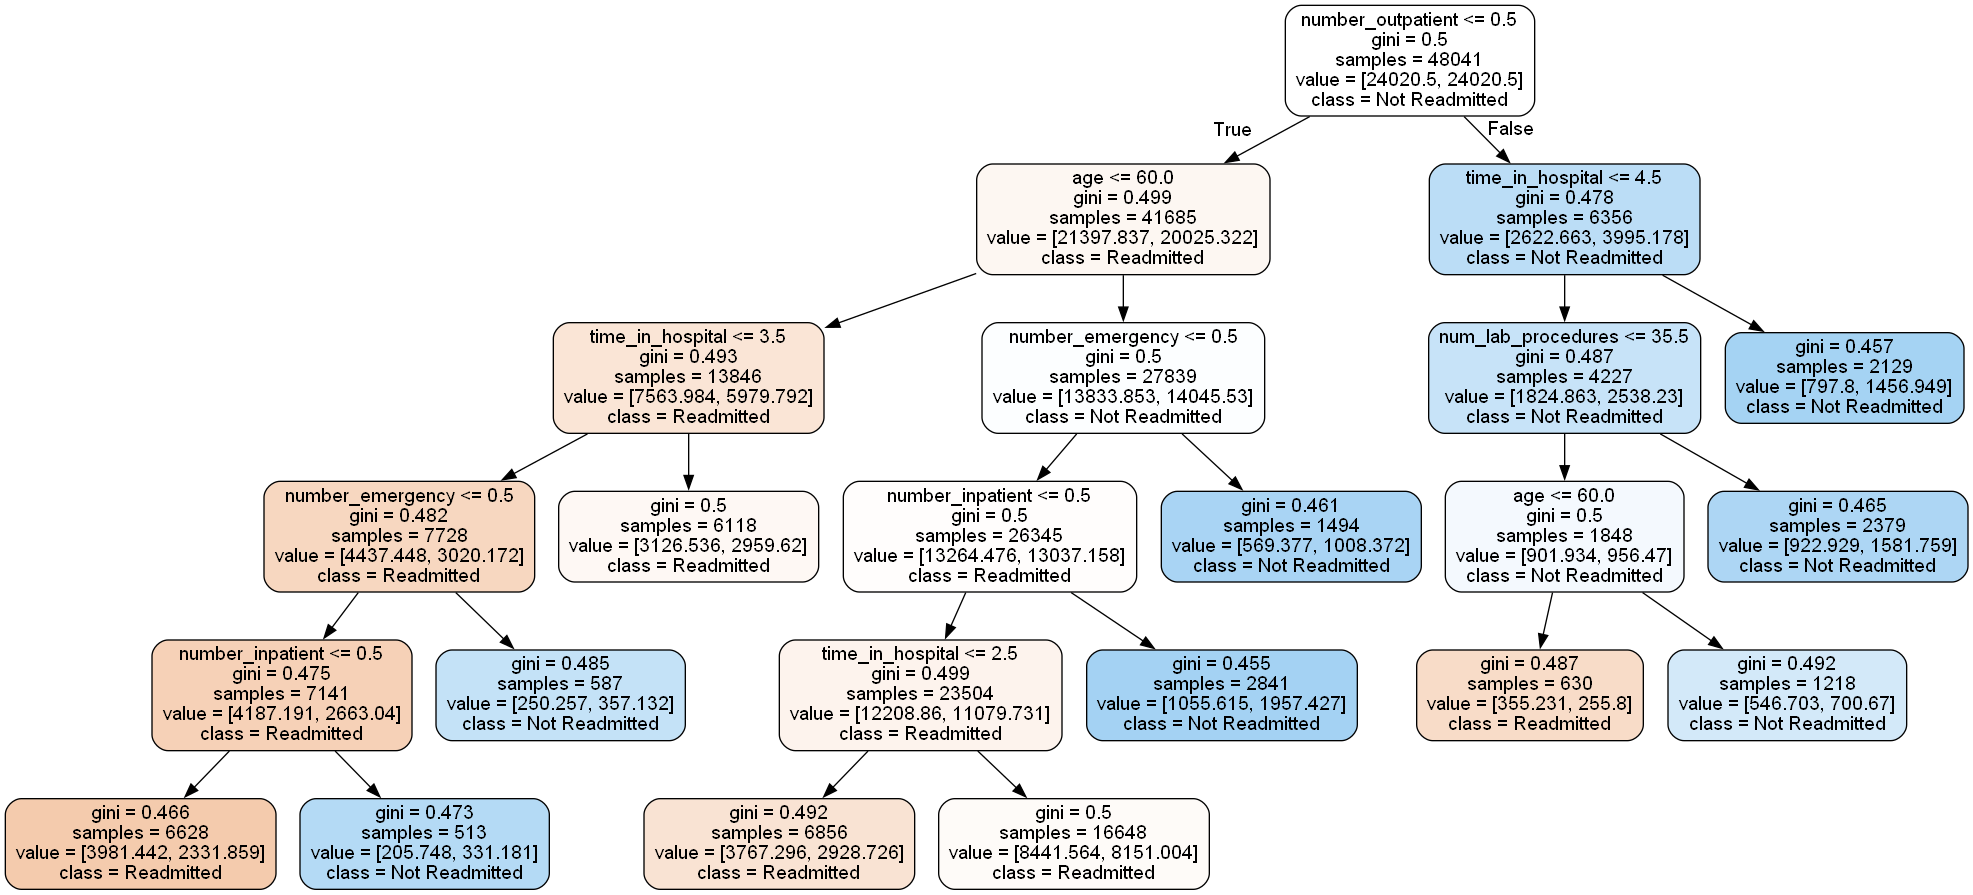

In [28]:
from sklearn.tree import export_graphviz
from IPython.display import Image
from six import StringIO  
tree_dot = StringIO()

import pydotplus

response = ['Readmitted', 'Not Readmitted']

export_graphviz(        
  clf_trim,        
  out_file = tree_dot,     
  feature_names=X_train.columns,        
  class_names=response,        
  rounded=True,        
  filled=True    
 )

tree_graph = pydotplus.graph_from_dot_data(tree_dot.getvalue())
Image(tree_graph.create_png())

In [29]:
import datetime
import pytz

datetime.datetime.now(pytz.timezone('US/Central')).strftime("%a, %d %B %Y %H:%M:%S")

'Sat, 11 February 2023 19:28:26'